# Parameter Initialization
What happen if we initialize the network parameter in different settings, like small random values or just zeros. In this notebook, we use TensorFlow as a handy tool to conduct several experiments and see what happens under different initialization.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_moons

%matplotlib inline

## Training Data
Here we use a fake dataset generated by method `make_moons` from `sklearn.datasets` module.

In [2]:
X, Y = make_moons(noise=0.2, random_state=0)
Y = Y[:, None]
print('X: ', X.shape)
print('Y: ', Y.shape)

X:  (100, 2)
Y:  (100, 1)


In [3]:
def plot_decision_boundary(model, X, y):
    """
    Function to plot dicision boundary.
    ---
    Arguments:
    model: func, (x) -> y
    X: np.array, with shape(n, 2)
    y: np.array, with shape(n, 1)
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=y)

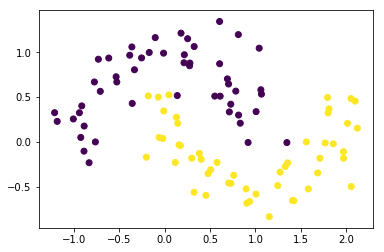

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=Y[:, 0])
plt.show()

## Intialization Functions
- Zero for $W$, small random value for $b$
- Small random value for $W$, zero for $b$
- Zero for both $W$ and $b$

In [5]:
def w_zero_b_random(n_in, n_out, stddev=0.1):
    w = np.zeros((n_in, n_out))
    b = np.random.randn(1, n_out) * stddev
    return w, b

def w_random_b_zero(n_in, n_out, stddev=0.1):
    w = np.random.randn(n_in, n_out) * stddev
    b = np.zeros((1, n_out))
    return w, b

def w_zero_b_zero(n_in, n_out):
    w = np.zeros((n_in, n_out))
    b = np.zeros((1, n_out))
    return w, b

## An n-layer Neural Network
Implement an n-layer neural network using TensorFlow. The network has structure like:
<center>(Linear + ReLU)*(n-1) -> (Linear + Sigmoid) -> Output</center>

In [6]:
class Model:
    def __init__(self, layer_dims=(2, 2, 1), init_fn=None, batch_size=None):
        """
        Arguments:
        layer_dims: tuple or list, at least with length greater than 1.
        init_fn: func, (n_in, n_out) -> w, b, initialization function.
        batch_size: int, optional, if provided, the string representation of Model is more informative.
        """
        self.layer_dims = layer_dims
        self.init_fn = init_fn
        self.batch_size = batch_size
        self.build_graph()
        
    def build_graph(self):
        layer_dims = self.layer_dims
        self.xph = tf.placeholder(tf.float32, shape=(self.batch_size, layer_dims[0]), name='X')
        self.yph = tf.placeholder(tf.float32, shape=(self.batch_size, 1), name='Y')
        endpoints = OrderedDict()
        endpoints['input'] = self.xph
        A = self.xph
        i = 0
        for i in range(len(layer_dims)-2):
            n_in, n_out = layer_dims[i], layer_dims[i+1]
            winit, binit = self.init_fn(n_in, n_out)
            w, b = tf.Variable(winit, name='w'+str(i+1), dtype=tf.float32), tf.Variable(binit, name='b'+str(i+1), dtype=tf.float32)
            Z = tf.add(tf.matmul(A, w), b, name='Z'+str(i+1))
            A = tf.nn.relu(Z, name='fc'+str(i+1))
            endpoints['layer ' + str(i+1)] = A
        winit, binit = self.init_fn(layer_dims[-2], layer_dims[-1])
        w, b = tf.Variable(winit, name='w'+str(i+2), dtype=tf.float32), tf.Variable(binit, name='b'+str(i+2), dtype=tf.float32)
        Z = tf.add(tf.matmul(A, w), b, name='Z'+str(i+2))
        A = tf.nn.sigmoid(Z, name='prob')
        endpoints['logit'] = Z
        endpoints['output'] = A
        self.endpoints = endpoints
    
    def _build_train(self, lr):
        losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.yph,
                                                         logits=self.endpoints['logit'])
        loss = tf.reduce_mean(losses)
        solver = tf.train.GradientDescentOptimizer(lr)
        train_op = solver.minimize(loss, global_step=tf.train.get_or_create_global_step())
        return loss, train_op
    
    def train(self, X, Y, n_steps=100, print_every=10, lr=1.5):
        """
        This training function should be called within a tf.Session context manager.
        ---
        Arguments:
        X: np.array, input data with shape(n_examples, n_features)
        Y: np.array, label with shape(n_examples, 1)
        n_steps: int, number of training iterations
        print_every: int, how oftern to print out the helper message
        lr: float, learning rate
        ---
        Returns:
        costs: list, containing the loss value after every iteration.
        """
        loss, train_op = self._build_train(lr)
        session = tf.get_default_session()
        session.run(tf.global_variables_initializer())
        feed_dict = {self.xph: X, self.yph: Y}
        costs = []
        for i in range(n_steps):
            loss_val = session.run(loss, feed_dict)
            if i % print_every == 0:
                print('Loss after %d steps: %.3f' % (i, loss_val))
            
            costs.append(loss_val)
            session.run(train_op, feed_dict)
        return costs
    
    def predict(self, X):
        """
        Do a prediction given input data.
        ---
        Arguments:
        X: np.array,
        ---
        Returns:
        pred: np.array, whose value is eighter 0 or 1
        """
        sess = tf.get_default_session()
        feed_dict = {self.xph: X}
        prob = sess.run(self.endpoints['output'], feed_dict)
        pred = np.zeros_like(prob)
        pred[prob > 0.5] = 1
        return pred
    
    def show_params(self):
        """
        Print out the weights of the neural network.
        """
        for weight in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
            print(weight.name, weight.eval())
        
    def __repr__(self):
        myself = '\n' + '\n'.join('{:>2} {:<15} {!r}{}'.format(i, key, value.dtype, value.shape)
                                  for i, (key, value) in enumerate(self.endpoints.items()))
        return myself

In [7]:
def test_with(init_fn, layer_dims,        
              n_steps=500,
              print_every=200,
              seed=3):
    with tf.Graph().as_default() as g:
        np.random.seed(seed)
        model = Model(layer_dims=layer_dims, 
                      init_fn=init_fn,
                      batch_size=None)
        print(model)
        with tf.Session() as sess:
            costs = model.train(X, Y, lr=1.2, n_steps=n_steps, print_every=print_every)
            writer = tf.summary.FileWriter('/tmp/model', graph=g)
            accuracy = np.mean(model.predict(X) == Y)
            print('Accuracy: %.3f' % accuracy)

            plt.figure(figsize=(24, 8))
            plt.subplot(131)
            plt.plot(costs)
            plt.title('Cost Function')
            plt.subplot(132)
            plt.scatter(X[:, 0], X[:, 1], c=model.predict(X))
            plt.title('Prediction')
            plt.subplot(133)
            plot_decision_boundary(lambda x: model.predict(x), X, Y)
            plt.title('Decision Boundary')
            plt.show()

### Training with w_random_b_zero


 0 input           tf.float32(?, 2)
 1 layer 1         tf.float32(?, 15)
 2 layer 2         tf.float32(?, 15)
 3 logit           tf.float32(?, 1)
 4 output          tf.float32(?, 1)
Loss after 0 steps: 0.692
Loss after 200 steps: 0.052
Loss after 400 steps: 0.011
Loss after 600 steps: 0.006
Loss after 800 steps: 0.004
Accuracy: 1.000


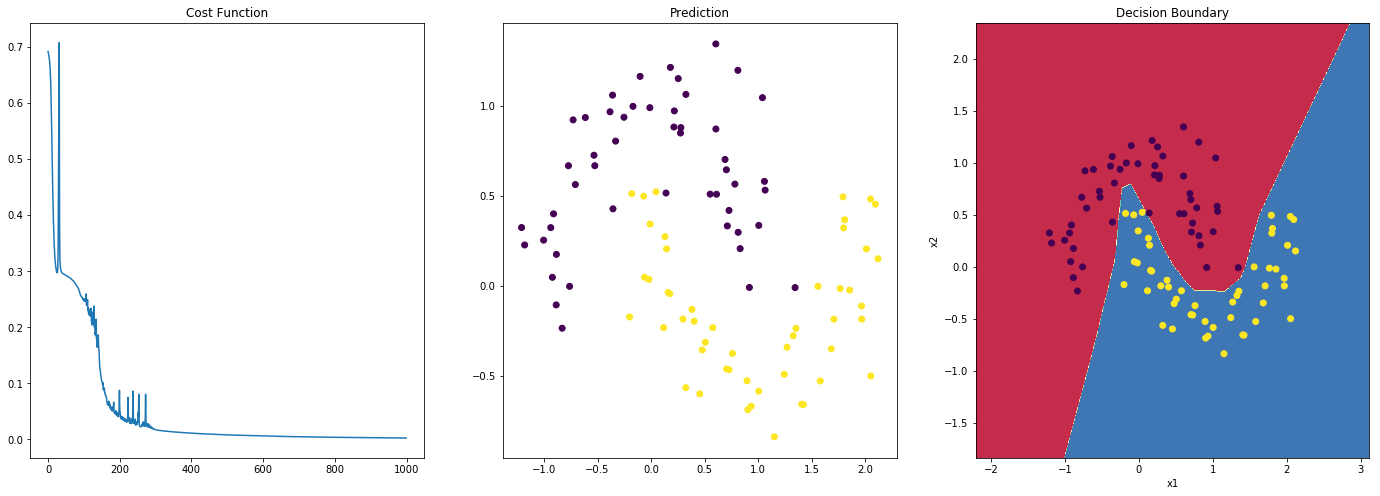

In [8]:
test_with(w_random_b_zero, layer_dims=(2, 15, 15, 1), n_steps=1000)

### Training with `w_zero_b_random`


 0 input           tf.float32(?, 2)
 1 layer 1         tf.float32(?, 15)
 2 layer 2         tf.float32(?, 15)
 3 logit           tf.float32(?, 1)
 4 output          tf.float32(?, 1)
Loss after 0 steps: 0.694
Loss after 200 steps: 0.693
Loss after 400 steps: 0.693
Loss after 600 steps: 0.693
Loss after 800 steps: 0.693
Accuracy: 0.500


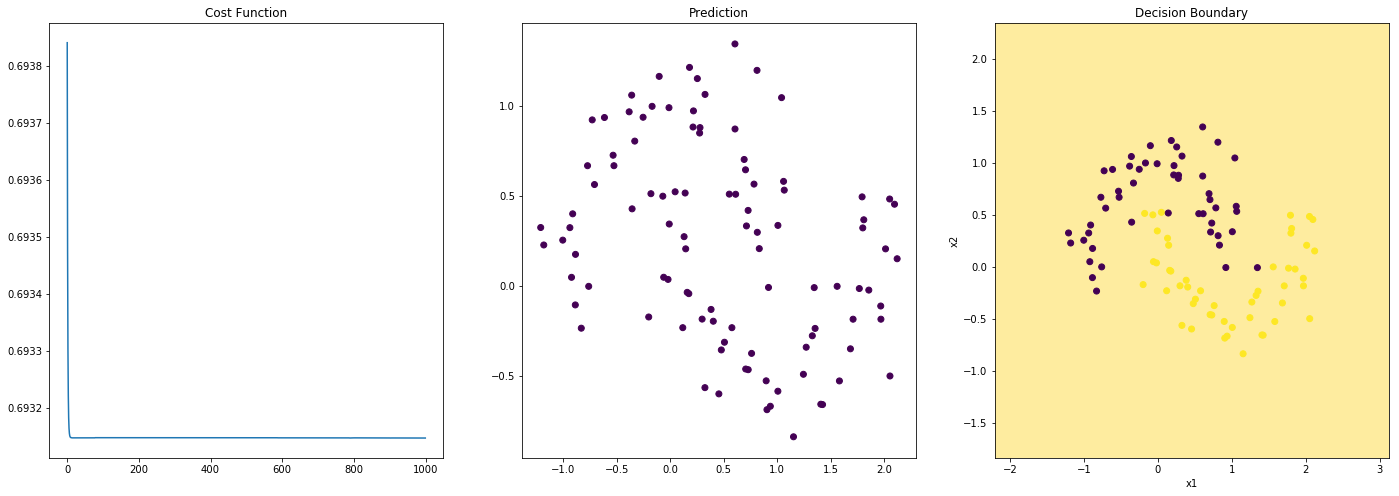

In [9]:
test_with(w_zero_b_random, layer_dims=(2, 15, 15, 1), n_steps=1000)

### Training with `w_zero_b_zero`


 0 input           tf.float32(?, 2)
 1 layer 1         tf.float32(?, 15)
 2 layer 2         tf.float32(?, 15)
 3 logit           tf.float32(?, 1)
 4 output          tf.float32(?, 1)
Loss after 0 steps: 0.693
Loss after 200 steps: 0.693
Loss after 400 steps: 0.693
Loss after 600 steps: 0.693
Loss after 800 steps: 0.693
Accuracy: 0.500


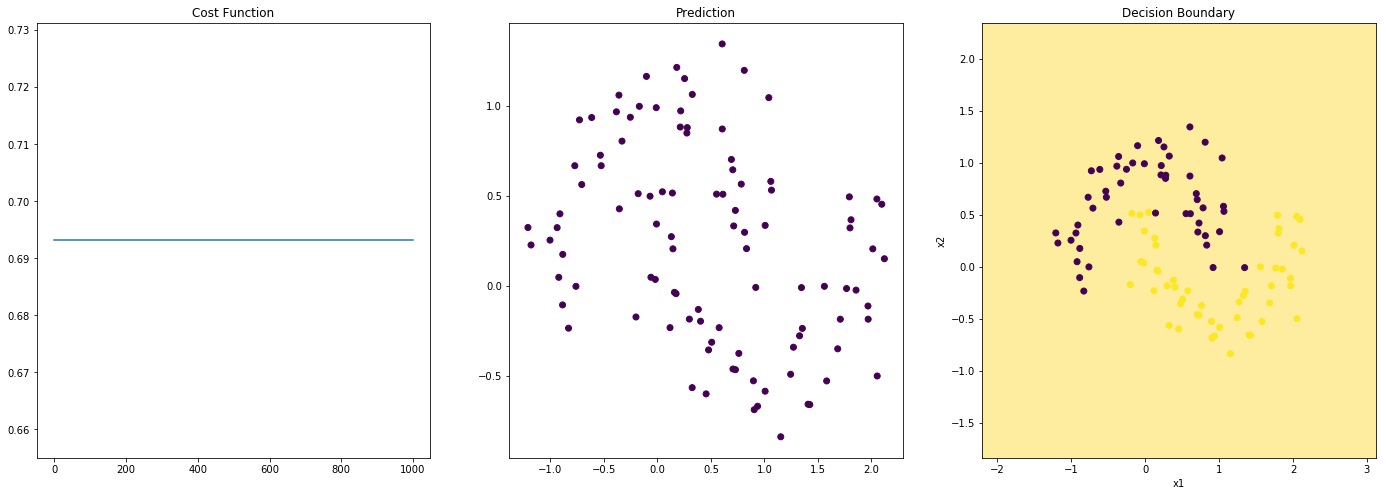

In [10]:
test_with(w_zero_b_zero, layer_dims=(2, 15, 15, 1), n_steps=1000)

### Train a perfect match
The smallest neural network that can yield an accuracy of 100% is:
<table style="width:40%">
  <tr>
    <td>**#layers**</td>
    <td>**layer_dims**</td> 
  </tr>
  <tr>
    <td>2</td>
    <td>(2, 55, 1)</td> 
  </tr>
   <tr>
    <td>3</td>
    <td>(2, 14, 14, 1)</td> 
  </tr>
   <tr>
    <td>4</td>
    <td>(2, 4, 4, 4, 1)</td> 
  </tr>
</table>


 0 input           tf.float32(?, 2)
 1 layer 1         tf.float32(?, 14)
 2 layer 2         tf.float32(?, 14)
 3 logit           tf.float32(?, 1)
 4 output          tf.float32(?, 1)
Loss after 0 steps: 0.692
Loss after 200 steps: 0.049
Loss after 400 steps: 0.011
Loss after 600 steps: 0.006
Loss after 800 steps: 0.004
Accuracy: 1.000


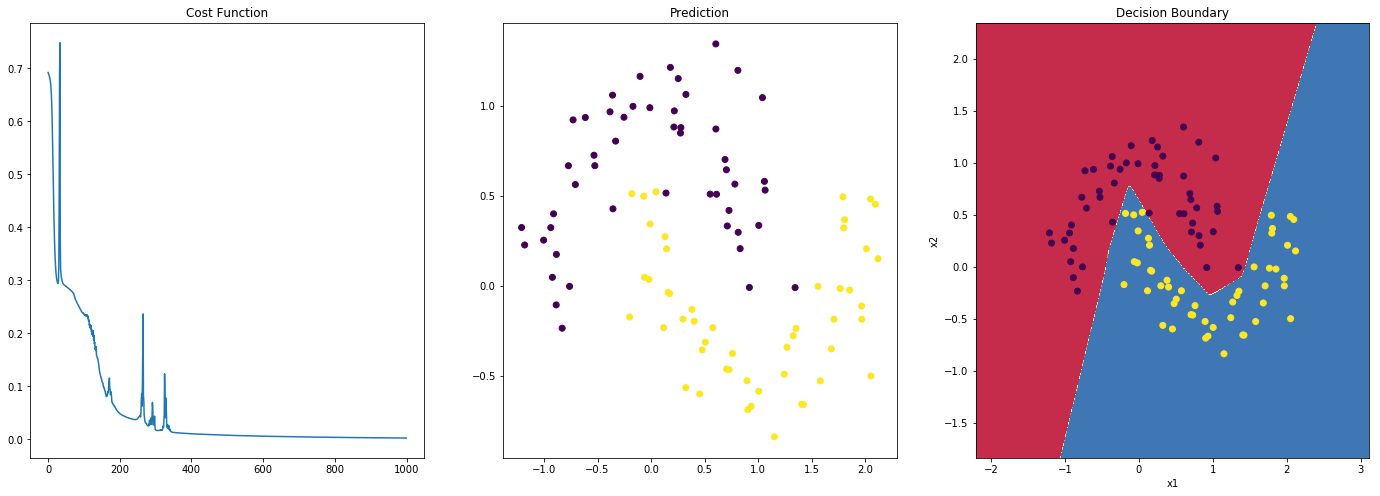

In [11]:
test_with(w_random_b_zero, layer_dims=(2, 14, 14, 1), n_steps=1000)

### Train using hand-crafted feature
As we can see from the table above, a 2-layer network needs about **55** hidden uints to figure out the pattern in the data. However, if we are to use a hand-crafted feature to train the network, the network is able to figure out the data pattern with just **5** hidden neurons.
Specifically, we will use the polynomial features:
$$
(x_1, x_2, x_1x_2, x_1^2, x_2^2)
$$
We're not saying that handcrafted feature is much better since most of the time it's not feasible.


 0 input           tf.float32(?, 5)
 1 layer 1         tf.float32(?, 5)
 2 logit           tf.float32(?, 1)
 3 output          tf.float32(?, 1)
Loss after 0 steps: 0.694
Loss after 200 steps: 0.107
Loss after 400 steps: 0.039
Accuracy: 1.000


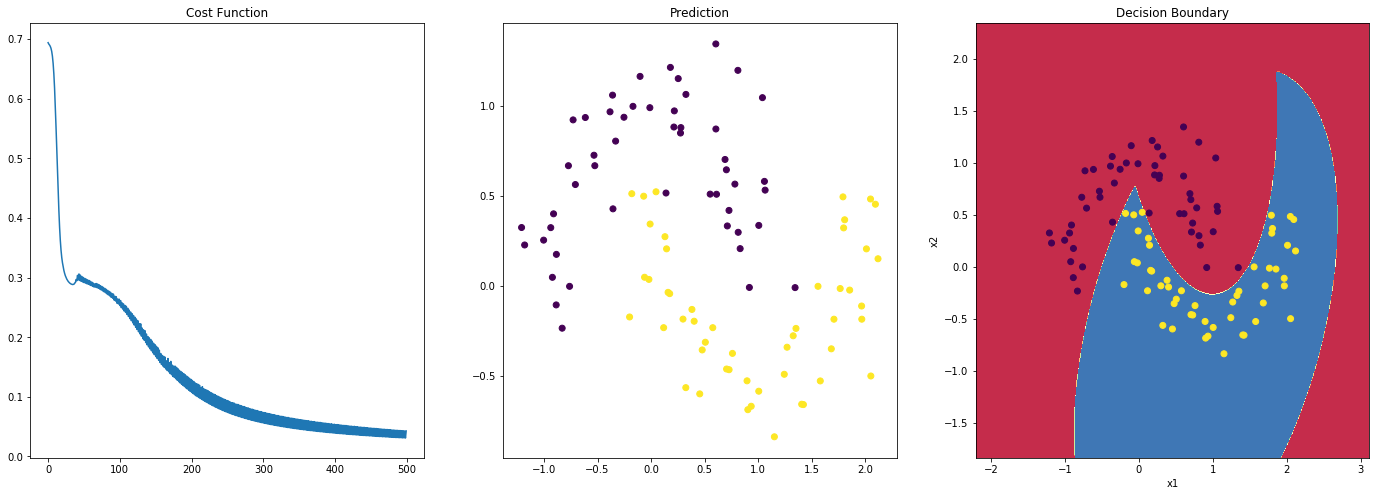

In [12]:
with tf.Graph().as_default() as g:
    np.random.seed(3)
    model = Model(layer_dims=(5, 5, 1), 
                  init_fn=w_random_b_zero,
                  batch_size=None)
    print(model)
    def poly_feature(X):
        x1 = X[:, 0]
        x2 = X[:, 1]
        feat = np.zeros((X.shape[0], 5))
        feat[:, 0] = x1
        feat[:, 1] = x2
        feat[:, 2] = x1 * x2
        feat[:, 3] = x1**2
        feat[:, 4] = x2**2
        return feat
    
    with tf.Session() as sess:
        X_poly = poly_feature(X)
        costs = model.train(X_poly, Y, lr=1.2, n_steps=500, print_every=200)
        writer = tf.summary.FileWriter('/tmp/model', graph=g)
        accuracy = np.mean(model.predict(X_poly) == Y)
        print('Accuracy: %.3f' % accuracy)

        plt.figure(figsize=(24, 8))
        plt.subplot(131)
        plt.plot(costs)
        plt.title('Cost Function')
        plt.subplot(132)
        plt.scatter(X[:, 0], X[:, 1], c=model.predict(poly_feature(X_poly)))
        plt.title('Prediction')
        plt.subplot(133)
        plot_decision_boundary(lambda x: model.predict(poly_feature(x)), X, Y)
        plt.title('Decision Boundary')
        plt.show()